In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [74]:
disease_types=['Apple___Apple_scab','Apple___Black_rot', 'Apple___Cedar_apple_rust','Apple___healthy',
               'Grape___healthy', 'Grape___Leaf_blight', 'Grape___Esca', 'Grape___Black_rot',
               'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

data_dir = '/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/Mini_SqueezeNet_New/Kodlar/dataset'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices

In [75]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [76]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

9385it [01:05, 144.12it/s]


Train Shape: (9385, 224, 224, 3)


In [77]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train)

In [78]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [9]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [10]:
from keras.applications import Xception
def build_xception():
    xception = Xception(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = xception(x)
    x = Flatten(name="flatten")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(11,activation = 'softmax', name='root')(x)
    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [11]:
model_xception= build_xception()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,555,783 (177.60 MB)

 Trainable params: 46,500,743 (177.39 MB)

 Non-trainable params: 55,040 (215.00 KB)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [13]:
hist=model_xception.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7121 - loss: 0.9818
Epoch 1: val_accuracy improved from -inf to 0.85988, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 103s 400ms/step - accuracy: 0.7133 - loss: 0.9776 - val_accuracy: 0.8599 - val_loss: 0.4958
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9848 - loss: 0.0494
Epoch 2: val_accuracy improved from 0.85988 to 0.96111, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.9611 - val_loss: 0.1414
Epoch 3/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9927 - loss: 0.0237
Epoch 3: val_accuracy improved from 0.96111 to 0.98348, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.9928 - loss: 0.0237 - val_accuracy: 0.9835 - val_loss: 0.0475
Epoch 4/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9953 - loss: 0.0119
Epoch 4: val_accura

In [14]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [15]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


In [16]:
y_pred=np.argmax(y_pred, axis=1)

In [17]:
Y_val=np.argmax(Y_val, axis=1)

In [18]:

print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  0.9994672349493873
F1_Skor:  0.9983337761011636
Hassasiyet:  0.9997495617330329
Duyarlılık:  0.996969696969697


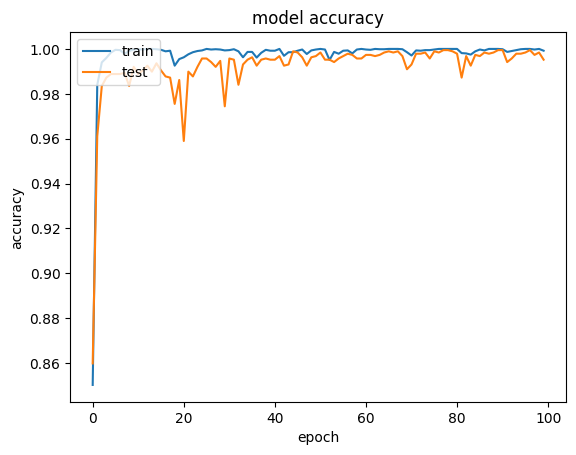

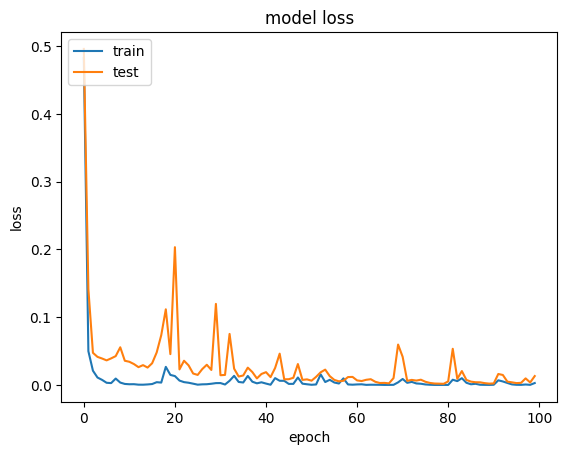

In [19]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[118   0   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  0   0   0 362   0   0   0   0   0   0   0]
 [  0   0   0   0  77   0   0   0   0   0   0]
 [  0   0   0   0   0 214   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0 252   0   0   0]
 [  0   0   0   0   0   0   0   0 182   0   0]
 [  0   0   0   1   0   0   0   0   0  29   0]
 [  0   0   0   0   0   0   0   0   0   0 206]]


<Axes: >

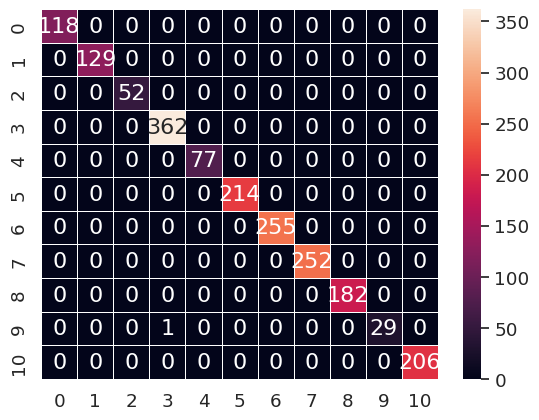

In [20]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

## SquuezeNEt


In [21]:
pip install keras_applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [59]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '-'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [60]:
X_train.shape[0:]

(7508, 224, 224, 3)

In [61]:
pip install tf_keras

In [62]:
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [63]:
import tensorflow as tf


model = SqueezeNet(input_shape = (X_train.shape[1:]), weights = None, classes = Y_train.shape[1],
                  use_bn_on_input = True)
# initiate RMSprop optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
loss_history = []
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "squeezenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 224, 224, 3)    │             12 │ input_layer_20[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 111, 111, 64)   │          1,792 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 111, 111, 64)   │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 55, 55, 64)     │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          1,040 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire2-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand1x1      │ (None, 55, 55, 64)     │              0 │ fire2-expand1x1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand3x3      │ (None, 55, 55, 64)     │              0 │ fire2-expand3x3[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-concat              │ (None, 55, 55, 128)    │              0 │ fire2-relu_expand1x1[… │
│ (Concatenate)             │                        │                │ fire2-relu_expand3x3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          2,064 │ fire2-concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire3-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire3-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire3-relu_squeeze1x1… │
├──────────────────────

 Total params: 728,151 (2.78 MB)

 Trainable params: 728,145 (2.78 MB)

 Non-trainable params: 6 (24.00 B)

In [64]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [65]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [66]:
hist=model.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1627 - loss: 2.3300
Epoch 1: val_accuracy improved from -inf to 0.19286, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.1627 - loss: 2.3295 - val_accuracy: 0.1929 - val_loss: 2.3755
Epoch 2/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2050 - loss: 2.0895
Epoch 2: val_accuracy improved from 0.19286 to 0.20565, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2059 - loss: 2.0876 - val_accuracy: 0.2056 - val_loss: 2.0971
Epoch 3/100
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3969 - loss: 1.6539
Epoch 3: val_accuracy improved from 0.20565 to 0.36441, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3972 - loss: 1.6527 - val_accuracy: 0.3644 - val_loss: 1.7668
Epoch 4/100
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4327 - loss: 1.5292
Epoch 4: val_accuracy improv

In [67]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [68]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [69]:
y_pred=np.argmax(y_pred, axis=1)

In [70]:
Y_val=np.argmax(Y_val, axis=1)

In [71]:

print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  0.9808204581779435
F1_Skor:  0.9784542109842627
Hassasiyet:  0.9771572336348268
Duyarlılık:  0.9801408072026304


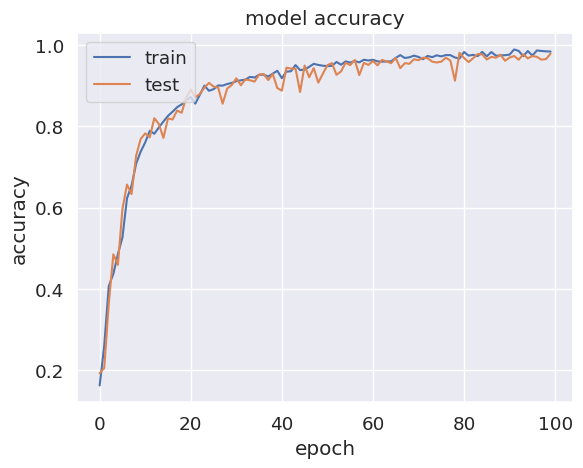

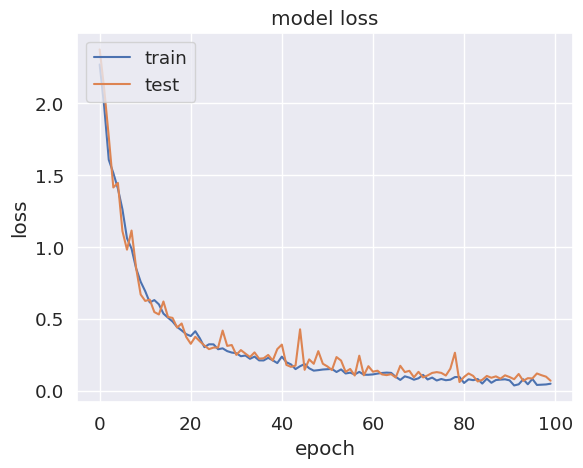

In [72]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[116   1   0   0   0   0   0   0   0   0   1]
 [  0 129   0   0   0   0   0   0   0   0   0]
 [  0   0  50   1   0   0   0   1   0   0   0]
 [  7   0   0 351   0   0   0   0   0   2   2]
 [  0   0   0   1  76   0   0   0   0   0   0]
 [  0   0   0   0   0 211   0   3   0   0   0]
 [  0   0   0   0   0   0 251   3   0   0   1]
 [  0   0   0   0   0   1   3 248   0   0   0]
 [  1   0   0   1   0   1   0   0 179   0   0]
 [  0   0   0   0   0   0   0   0   0  29   1]
 [  3   0   0   0   0   0   0   0   2   0 201]]


<Axes: >

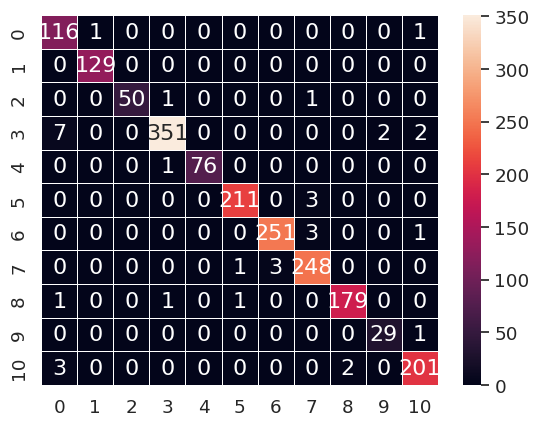

In [73]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

### ShuffleNEt

In [136]:
from keras import backend as K
K.clear_session()

In [122]:
pip install Keras

In [123]:

from keras.utils import plot_model
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.engine.topology import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K
import os
from keras import backend as K
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np
from keras.layers import Lambda

def channel_split(inputs, name):
    """Splits the input tensor into two parts along the channel axis."""
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1

    # Calculate the number of channels and split size
    channels = tf.keras.backend.int_shape(inputs)[channel_axis]
    split_channels = channels // 2

    # Use Lambda layers to split the channels
    return Lambda(lambda x: x[..., :split_channels], name=name + '_split1')(inputs), \
           Lambda(lambda x: x[..., split_channels:], name=name + '_split2')(inputs)

def channel_shuffle(x):
    height, width, channels = x.shape[1:]  # Tuple'dan boyutları al
    channels_per_split = channels // 2
    x = tf.reshape(x, [-1, height, width, 2, channels_per_split])  # tf.reshape kullan
    x = tf.transpose(x, perm=[0, 1, 2, 4, 3])  # Permute to shuffle channels
    x = tf.reshape(x, [-1, height, width, channels])  # tf.reshape kullan
    return x

def shuffle_unit(inputs, out_channels, bottleneck_ratio, strides=2, stage=1, block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}-block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)

    if strides < 2:
        c_hat, c = channel_split(inputs, '{}_spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding='same', name='{}_1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}_relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}_3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}_1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}_relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}_concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}_3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}_bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}_1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}_relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}_concat_2'.format(prefix))([x, s2])

    # tf.keras.backend.int_shape ile output_shape belirleyin
    ret_shape = tf.keras.backend.int_shape(ret)
    ret = Lambda(channel_shuffle, output_shape=(ret_shape[1], ret_shape[2], ret_shape[3]), name='{}_channel_shuffle'.format(prefix))(ret)

    return ret

def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(224,224,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=11):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('imagenet', by_name=True)

    return model


In [124]:
model = ShuffleNetV2(input_shape=(224, 224, 3), classes=11)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 24)   │            648 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 24)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_1   │ (None, 56, 56, 116)    │          2,900 │ maxpool1[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 56, 56, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_relu_1x1co… │ (None, 56, 56, 116)    │              0 │ stage2-block1_bn_1x1c… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv   │ (None, 28, 28, 116)    │          1,160 │ stage2-block1_relu_1x… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv_2 │ (None, 28, 28, 24)     │            240 │ maxpool1[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 116)    │            464 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 24)     │             96 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_2   │ (None, 28, 28, 116)    │         13,572 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1_conv_3  │ (None, 28, 28, 116)    │          2,900 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1_con… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,030,015 (15.37 MB)

 Trainable params: 4,001,895 (15.27 MB)

 Non-trainable params: 28,120 (109.84 KB)

None


In [138]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [139]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 24)   │            648 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 24)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_1   │ (None, 56, 56, 116)    │          2,900 │ maxpool1[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 56, 56, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_relu_1x1co… │ (None, 56, 56, 116)    │              0 │ stage2-block1_bn_1x1c… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv   │ (None, 28, 28, 116)    │          1,160 │ stage2-block1_relu_1x… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv_2 │ (None, 28, 28, 24)     │            240 │ maxpool1[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 116)    │            464 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 24)     │             96 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_2   │ (None, 28, 28, 116)    │         13,572 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1_conv_3  │ (None, 28, 28, 116)    │          2,900 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1_con… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,030,015 (15.37 MB)

 Trainable params: 4,001,895 (15.27 MB)

 Non-trainable params: 28,120 (109.84 KB)

None


In [127]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [134]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [140]:
hist=model.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/50
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9179 - loss: 0.2506

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-140-aa7c9dc4a5b5>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

ptxas exited with non-zero error code 2, output: : If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_592051]

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [ ]:
y_pred = saved_model.predict(X_val)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
Y_val=np.argmax(Y_val, axis=1)

In [ ]:

print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

In [ ]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size